In [1]:
import sys, os
sys.path.append(os.path.abspath('../'))

import cleanlab
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold

from cleanlab.pruning import get_noise_indices

from pathlib import Path

import numpy as np
import cv2
import os
from matplotlib import pyplot as plt


from pathlib import Path
from glob import glob

import numpy as np
from numpy import random
import tensorflow as tf
from sklearn.base import BaseEstimator

import cv2

from tqdm import tqdm
from tensorflow.python.keras.preprocessing import dataset_utils

import utils
from model import DataCentricClassifier

tf.random.set_seed(123)

In [2]:
experiment_dir = Path("../experiments/original/")
model_path = str(experiment_dir / "checkpoints" / "best_model")
dataset_dir = str(experiment_dir / "data" / "train")
image_paths, image_labels, class_names = utils.get_image_paths_and_labels(dataset_dir, shuffle=False, random_seed=None)

Found 2067 files belonging to 10 classes.


In [3]:
classifier = DataCentricClassifier(
    model_path=model_path,
    image_paths=image_paths,
    image_labels=image_labels,
    class_names=class_names,
    batch_size=8,
    random_seed=123,
    epoch=1
)
classifier.load_weights()

Creating ResNet50 model...
Loading weights from ../experiments/original/checkpoints/best_model


/home/omar/.cache/pypoetry/virtualenvs/dcc-8g-IaL7o-py3.8/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [4]:
train_size = len(image_paths)

In [5]:
X_train = np.arange(train_size)
y_train = image_labels

In [6]:
classifier.fit(X_train, y_train)

Filtered dataset size: 2067
259/259 [==============================] - 10s 33ms/step - loss: 0.2168 - accuracy: 0.9531


In [8]:
def estimate_confident_joint_and_cv_pred_proba(
        X,
        s,
        clf,
        cv_n_folds=5,
        thresholds=None,
        seed=None,
        calibrate=True,
):
    cleanlab.latent_estimation.assert_inputs_are_valid(X, s)
    # Number of classes
    K = len(np.unique(s))

    # Ensure labels are of type np.array()
    s = np.asarray(s)

    # Create cross-validation object for out-of-sample predicted probabilities.
    # CV folds preserve the fraction of noisy positive and
    # noisy negative examples in each class.
    kf = StratifiedKFold(n_splits=cv_n_folds, shuffle=True, random_state=seed)

    # Intialize psx array
    psx = np.zeros((len(s), K))

    # Split X and s into "cv_n_folds" stratified folds.
    for k, (cv_train_idx, cv_holdout_idx) in enumerate(kf.split(X, s)):
        clf.load_weights()

        # Select the training and holdout cross-validated sets.
        X_train_cv, X_holdout_cv = X[cv_train_idx], X[cv_holdout_idx]
        s_train_cv, s_holdout_cv = s[cv_train_idx], s[cv_holdout_idx]

        # Fit the clf classifier to the training set and
        # predict on the holdout set and update psx.
        clf.fit(X_train_cv, s_train_cv)
        psx_cv = clf.predict_proba(X_holdout_cv)  # P(s = k|x) # [:,1]
        psx[cv_holdout_idx] = psx_cv

    # Compute the confident counts, a K x K matrix for all pairs of labels.
    confident_joint = cleanlab.latent_estimation.compute_confident_joint(
        s=s,
        psx=psx,  # P(s = k|x)
        thresholds=thresholds,
        calibrate=calibrate,
    )

    return confident_joint, psx

In [9]:
cj, psx = estimate_confident_joint_and_cv_pred_proba(X_train, y_train, clf=classifier)

Loading weights from ../experiments/original/checkpoints/best_model
Filtered dataset size: 1653
207/207 [==============================] - 6s 27ms/step - loss: 0.2318 - accuracy: 0.9419
Filtered dataset size: 414


100%|██████████| 414/414 [00:17<00:00, 23.83it/s]


Loading weights from ../experiments/original/checkpoints/best_model
Filtered dataset size: 1653
207/207 [==============================] - 7s 33ms/step - loss: 0.2412 - accuracy: 0.9468
Filtered dataset size: 414


100%|██████████| 414/414 [00:17<00:00, 24.18it/s]


Loading weights from ../experiments/original/checkpoints/best_model
Filtered dataset size: 1654
207/207 [==============================] - 7s 32ms/step - loss: 0.2360 - accuracy: 0.9456
Filtered dataset size: 413


100%|██████████| 413/413 [00:17<00:00, 24.08it/s]


Loading weights from ../experiments/original/checkpoints/best_model
Filtered dataset size: 1654
207/207 [==============================] - 6s 30ms/step - loss: 0.2209 - accuracy: 0.9498
Filtered dataset size: 413


100%|██████████| 413/413 [00:16<00:00, 25.63it/s]


Loading weights from ../experiments/original/checkpoints/best_model
Filtered dataset size: 1654
207/207 [==============================] - 6s 31ms/step - loss: 0.2314 - accuracy: 0.9450
Filtered dataset size: 413


100%|██████████| 413/413 [00:18<00:00, 22.75it/s]


In [10]:
cj, psx

(array([[254,   1,   6,   0,   0,   0,   0,   0,   0,   0],
        [  3, 117,  28,   2,   2,   5,   0,   0,   0,   0],
        [  0,   3, 183,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 275,   3,   0,   0,   3,   0,   0],
        [  0,   0,   0,   3, 192,   0,   0,   0,   0,   1],
        [  0,   0,   0,   0,   5, 143,  32,   1,   0,   0],
        [  0,   0,   0,   0,   0,   1, 189,   3,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 199,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   1, 233,   0],
        [  0,   0,   0,   0,   1,   0,   0,   0,   0, 178]]),
 array([[9.58390534e-01, 2.70888046e-03, 1.75215036e-03, ...,
         6.05450550e-05, 2.68113858e-04, 8.81445128e-03],
        [9.93710697e-01, 5.44295995e-04, 4.33718815e-04, ...,
         1.51567122e-06, 8.69468495e-04, 4.35154373e-03],
        [6.56699061e-01, 3.22397947e-01, 1.23622334e-02, ...,
         1.67635335e-05, 1.68025406e-04, 1.67829814e-04],
        ...,
        [1.23958150e-03, 

In [11]:
psx.shape

(2067, 10)

In [12]:
est_py, est_nm, est_inv = cleanlab.latent_estimation.estimate_latent(cj, y_train)

In [13]:
max_images = 32

noise_idx = cleanlab.pruning.get_noise_indices(y_train, psx, est_inv, prune_method='prune_by_class', confident_joint=cj)
print('Number of estimated errors in the dataset:', sum(noise_idx))

pred = np.argmax(psx, axis=1)
ordered_noise_idx = np.argsort(np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx])[::-1]

# if sum(noise_idx) >= max_images:
prob_given = np.asarray([psx[i][j] for i,j in enumerate(y_train)])[noise_idx][ordered_noise_idx][:max_images]
prob_pred = np.asarray([psx[i][j] for i,j in enumerate(pred)])[noise_idx][ordered_noise_idx][:max_images]
img_idx = np.arange(len(noise_idx))[noise_idx][ordered_noise_idx][:max_images]
label4viz = y_train[noise_idx][ordered_noise_idx][:max_images]
pred4viz = pred[noise_idx][ordered_noise_idx][:max_images]

img_labels = ["given: "+str( class_names[label4viz[w]])+" | conf: "+str(np.round(prob_given[w],3)) for w in range(len(label4viz))]
img_preds = ["pred: "+str( class_names[pred4viz[w]])+" | conf: "+str(np.round(prob_pred[w],3)) for w in range(len(pred4viz))]


Number of estimated errors in the dataset: 104


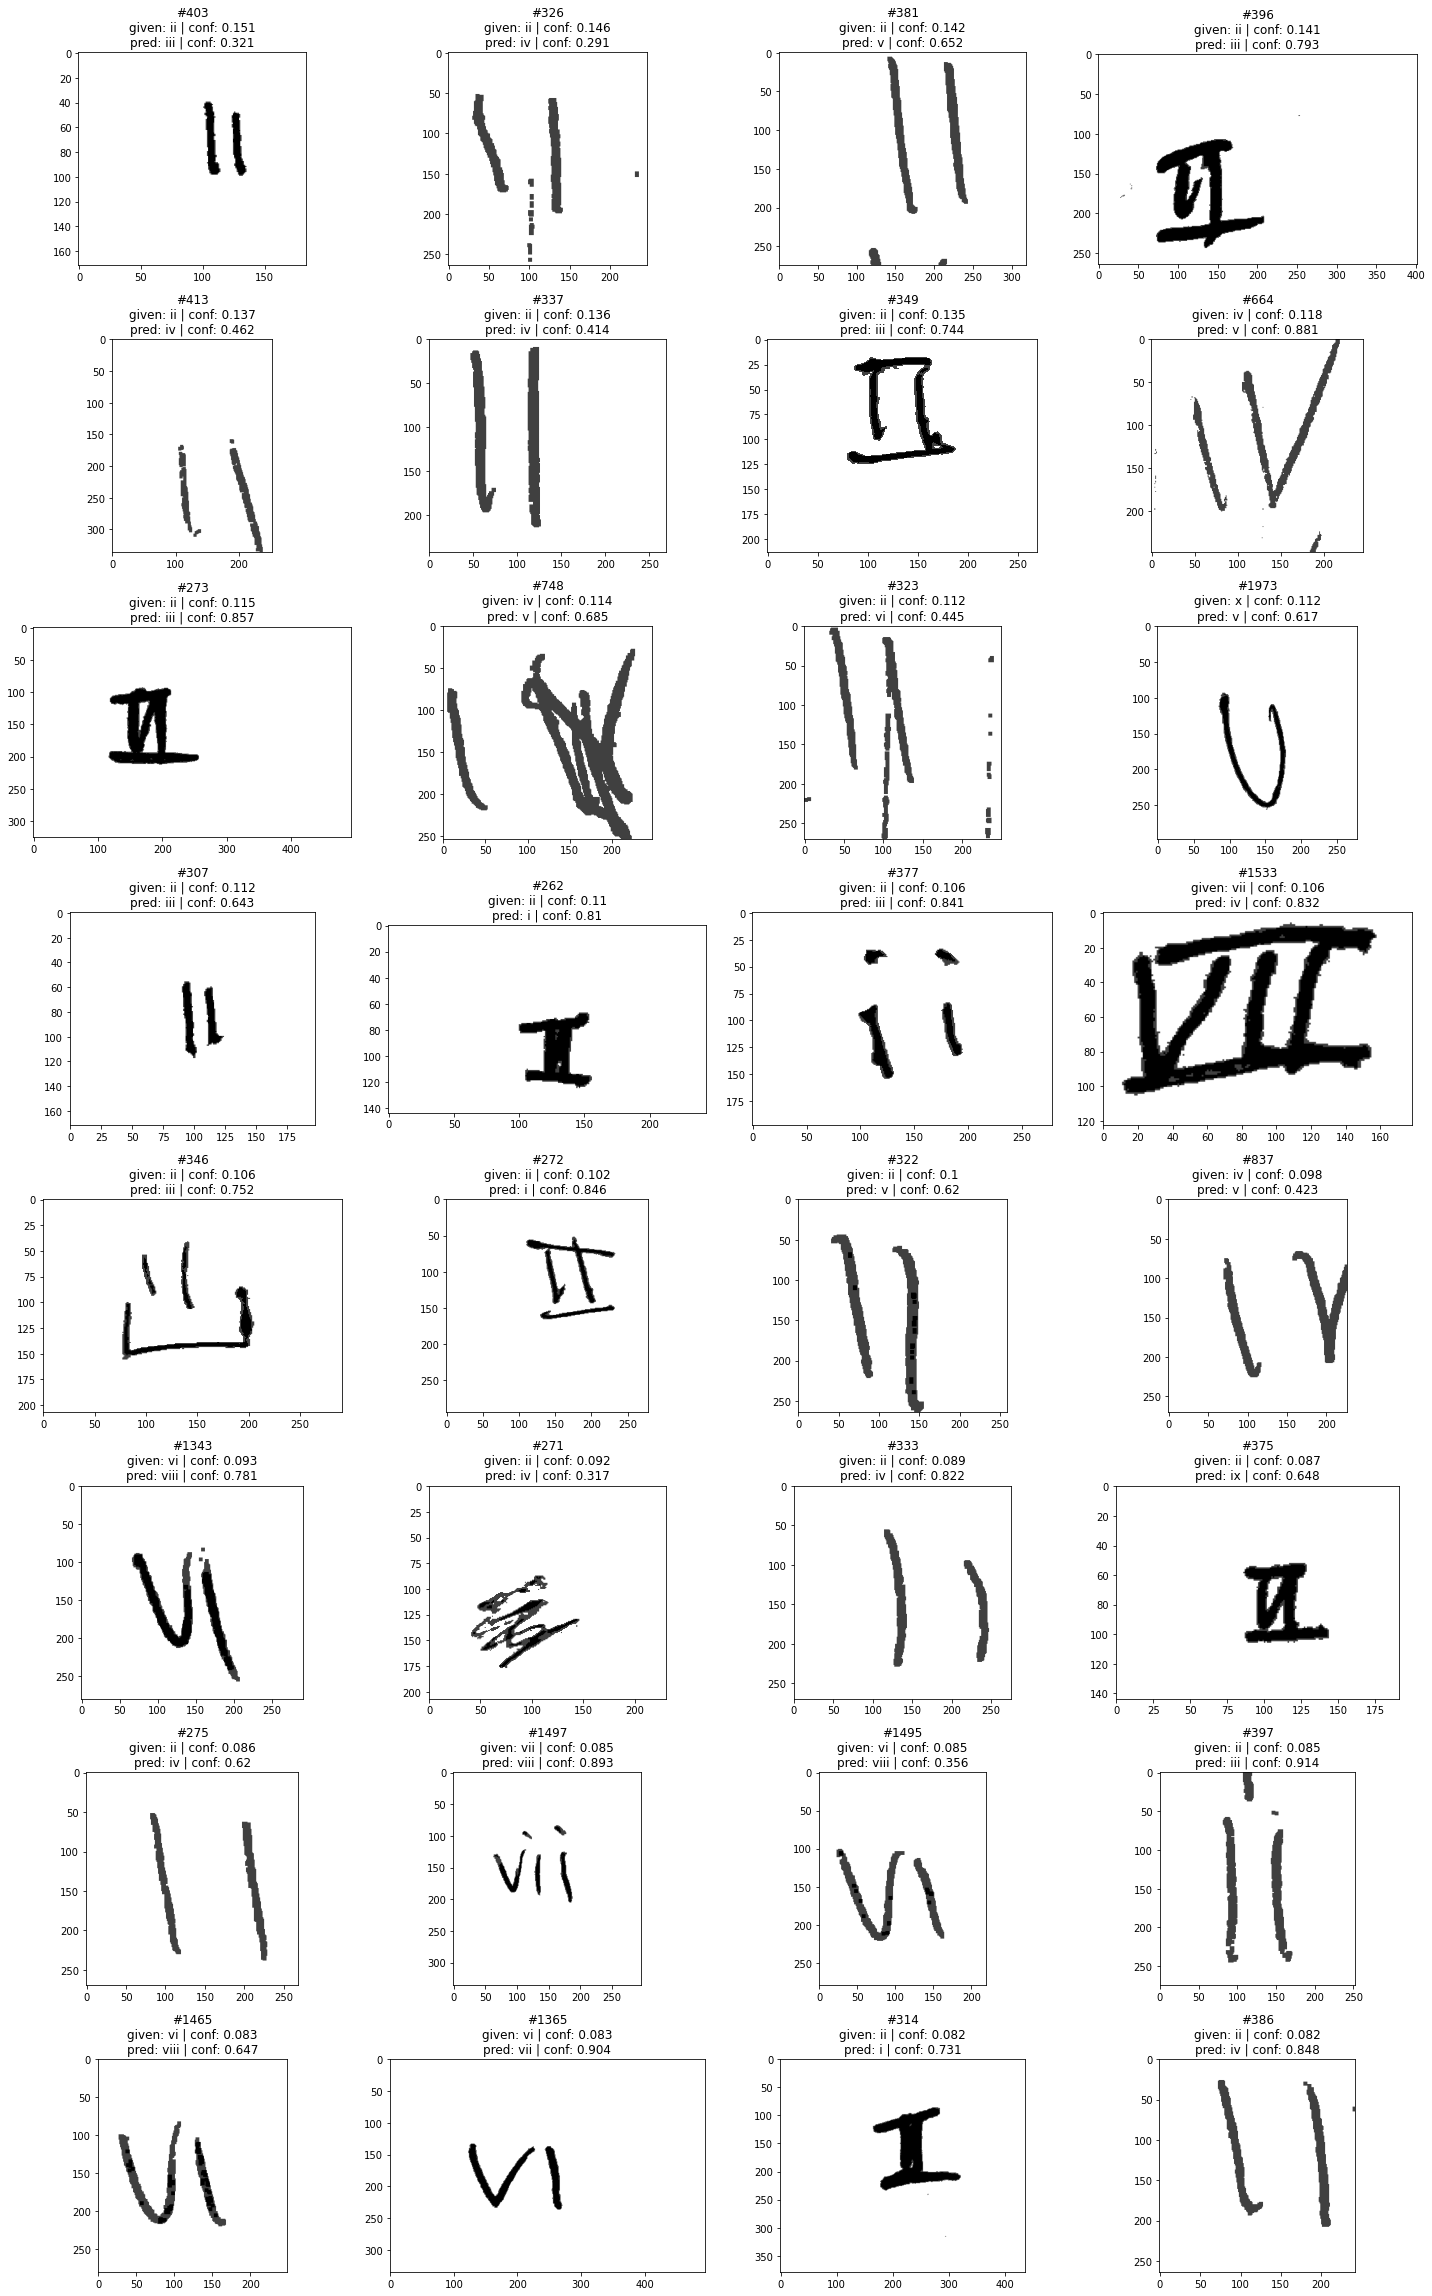

In [18]:
ncols = 4
nrows = int(np.ceil(len(img_labels) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
for ax, image_index, image_label, image_pred in zip(axes.ravel(), img_idx, img_labels, img_preds):
    image_path = image_paths[image_index]
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax.set_title(f"#{image_index}\n{image_label}\n{image_pred}")
    ax.imshow(img, cmap = "gray", vmin=0, vmax=255)
    #ax.axis('off')
fig.tight_layout()